In [11]:
# ----------------------------- 라이브러리 임포트 -----------------------------
import os
import numpy as np
import torch
import torch.nn as nn
import librosa
import librosa.display
import matplotlib.pyplot as plt
import re
from typing import Tuple

from matplotlib import font_manager

# 시스템 내 설치된 폰트 확인
font_manager.findSystemFonts()

# 한글 폰트 설정 (macOS 기준, Windows나 Linux는 폰트 경로를 변경해야 할 수 있음)
font_location = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_name = font_manager.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

In [12]:
# ----------------------------- 함수 정의 -----------------------------
def sanitize_name(name: str) -> str:
    """
    문자열에서 알파벳, 숫자, 언더스코어만 남기고 나머지는 제거합니다.
    """
    return re.sub(r"[^a-zA-Z0-9_]", "", name.replace(" ", "_"))

def extract_features(file_path: str, n_mfcc: int = 40, max_len: int = 174, visualize: bool = False) -> np.ndarray:
    """
    오디오 파일에서 다양한 특징을 추출하고 시각화합니다.
    
    Parameters:
    - file_path: 오디오 파일 경로
    - n_mfcc: 추출할 MFCC 계수 수
    - max_len: 패딩 또는 자를 길이
    - visualize: 시각화 여부
    
    Returns:
    - mfcc: 추출된 MFCC 특징
    """
    try:
        y, sr = librosa.load(file_path, sr=None, mono=True)

        # 원본 파형 시각화
        if visualize:
            plt.figure(figsize=(14, 5))
            librosa.display.waveshow(y, sr=sr)
            plt.title("원본 오디오 파형")
            plt.xlabel("시간 (초)")
            plt.ylabel("진폭")
            plt.show()

        # 스펙트로그램 시각화
        if visualize:
            D = np.abs(librosa.stft(y))
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis='time', y_axis='linear')
            plt.colorbar(format='%+2.0f dB')
            plt.title('스펙트로그램 (Linear Scale)')
            plt.xlabel("시간 (초)")
            plt.ylabel("주파수 (Hz)")
            plt.show()

        # 멜 스펙트로그램 시각화
        if visualize:
            S = librosa.feature.melspectrogram(y=y, sr=sr)
            S_DB = librosa.power_to_db(S, ref=np.max)
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title('멜 스펙트로그램')
            plt.xlabel("시간 (초)")
            plt.ylabel("멜 주파수")
            plt.show()

        # 크로마그램 시각화
        if visualize:
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
            plt.colorbar()
            plt.title('크로마그램')
            plt.xlabel("시간 (초)")
            plt.ylabel("크로마")
            plt.show()

        # MFCC 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # MFCC 시각화
        if visualize:
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(mfcc, x_axis='time')
            plt.colorbar()
            plt.title("MFCC")
            plt.xlabel("시간 (초)")
            plt.ylabel("MFCC 계수")
            plt.tight_layout()
            plt.show()

        # 패딩 또는 자르기
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode="constant")
        else:
            mfcc = mfcc[:, :max_len]

        return mfcc
    except Exception as e:
        print(f"특징 추출 실패: {file_path}, 에러: {e}")
        return np.zeros((n_mfcc, max_len))

def load_model(model: nn.Module, path: str, device: torch.device) -> nn.Module:
    """
    모델을 지정된 경로에서 로드합니다.
    
    Parameters:
    - model: 로드할 모델 객체
    - path: 모델 파일 경로
    - device: 사용할 디바이스
    
    Returns:
    - model: 로드된 모델
    """
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model


In [13]:
# ----------------------------- 모델 정의 -----------------------------
class CNNModel(nn.Module):
    """
    CNN 모델 정의 클래스
    """
    def __init__(
        self,
        input_shape: Tuple[int, int, int],
        num_classes: int,
        dropout_rate: float = 0.5,
        l2_reg: float = 0.001,
    ):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(3, 3), padding="same")
        self.pool1 = nn.MaxPool2d((2, 2))
        self.bn1 = nn.BatchNorm2d(128)

        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding="same")
        self.pool2 = nn.MaxPool2d((2, 2))
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding="same")
        self.pool3 = nn.MaxPool2d((2, 2))
        self.bn3 = nn.BatchNorm2d(32)

        conv_output_size = self._get_conv_output(input_shape)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(64, num_classes)
        self.l2_reg = l2_reg

    def _get_conv_output(self, shape: Tuple[int, int, int]) -> int:
        bs = 1
        input = torch.zeros(bs, *shape)
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def _forward_features(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.bn3(x)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._forward_features(x)

        # 중간 특징 맵 시각화 (선택 사항)
        # conv_output = x.detach().cpu().numpy()
        # plt.figure(figsize=(12, 6))
        # plt.imshow(conv_output[0, 0, :, :], aspect='auto', origin='lower')
        # plt.title("합성곱 계층 출력")
        # plt.colorbar()
        # plt.show()

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x


In [14]:
# ----------------------------- GPU 및 CPU 설정 -----------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}\n")

사용 중인 디바이스: mps



In [15]:
# 모델 저장 디렉토리 설정 (Google Drive 내 경로로 변경)
models_output_dir = "../models"  # 모델 저장 디렉토리

# 악기 리스트 가져오기
# 모델 디렉토리 내의 모델 파일들을 탐색하여 악기 이름을 추출
model_files = [f for f in os.listdir(models_output_dir) if f.startswith("best_model_") and f.endswith(".pt")]
all_instruments = [f[len("best_model_"):-len(".pt")] for f in model_files]
all_instruments = [instr.replace("_", " ") for instr in all_instruments]  # 언더스코어를 스페이스로 변환
print(f"악기 리스트: {all_instruments}\n")


악기 리스트: ['clarinet', 'violin', 'cello', 'oboe', 'saxophone', 'double bass', 'clash cymbals', 'tuba', 'trumpet', 'flute', 'bass clarinet', 'french horn', 'bassoon', 'tambourine', 'viola', 'trombone']



오디오 파일에서 특징 추출 및 시각화 중...


/Users/reo/miniforge3/envs/torch-mac/lib/python3.12/site-packages/librosa/display.py:801: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  ax.figure.canvas.draw_idle()


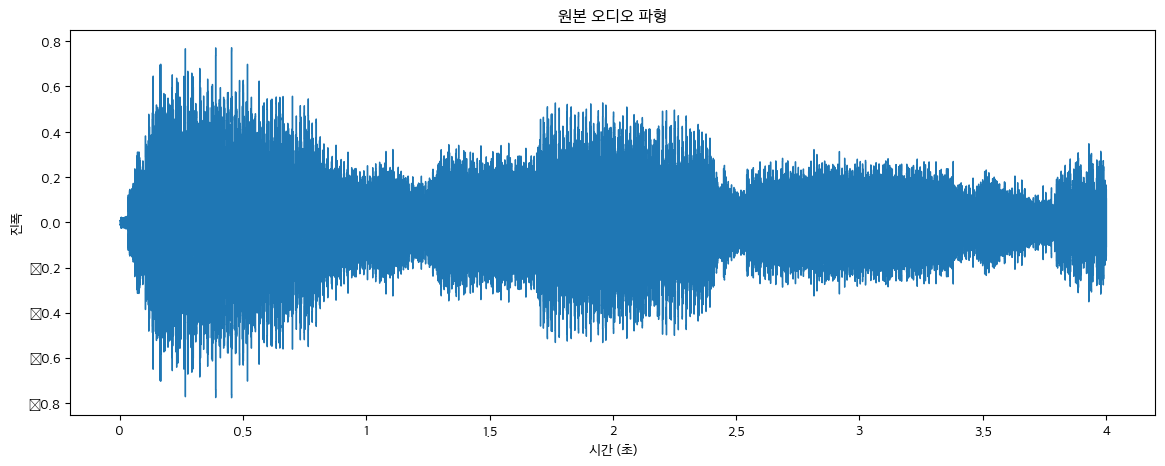

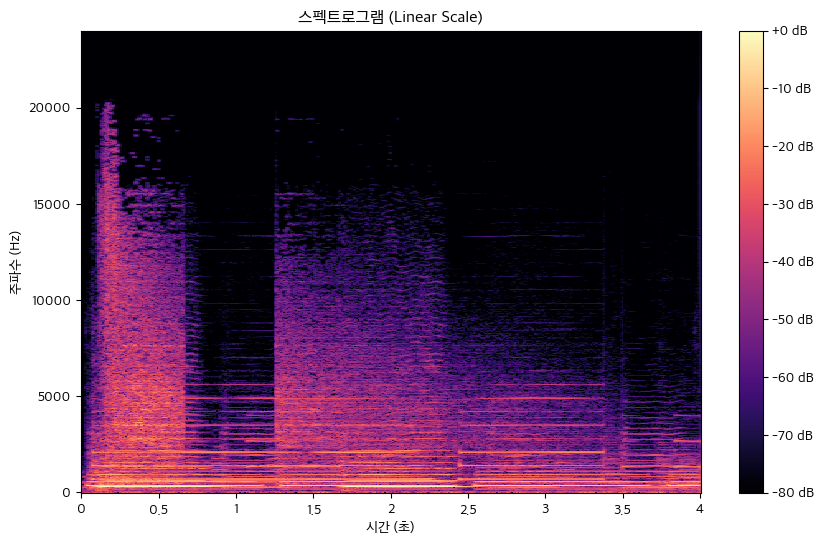

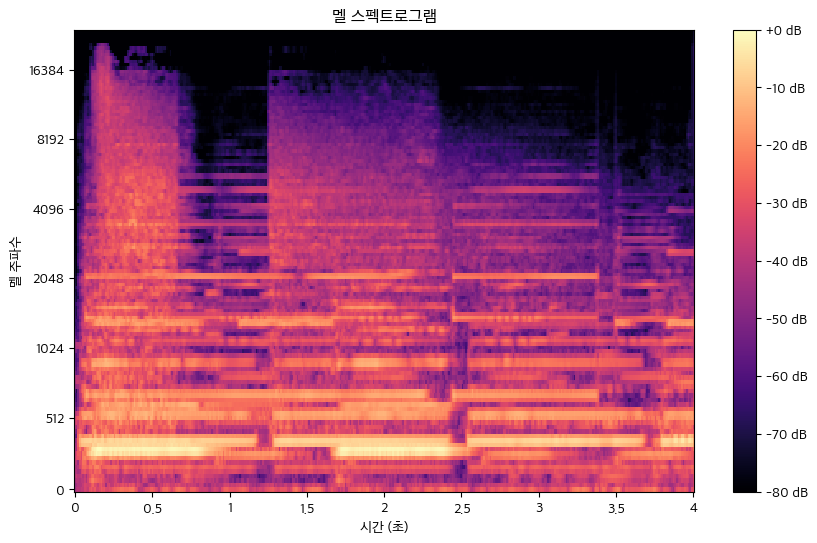

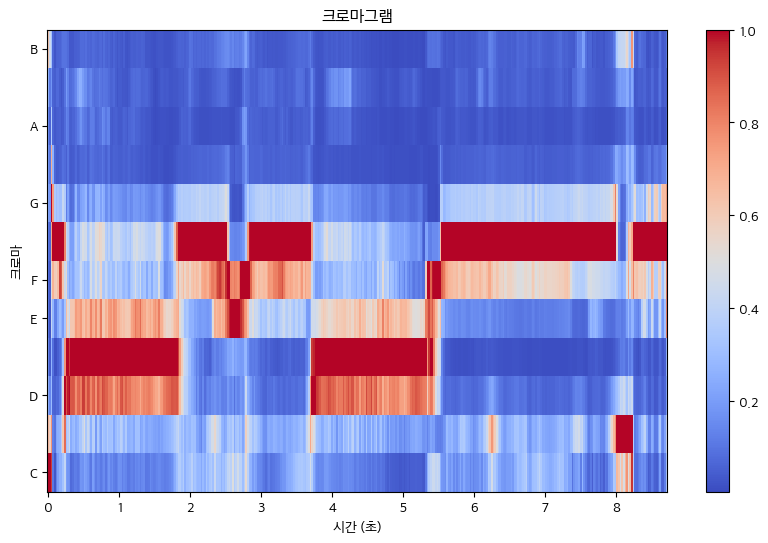

/var/folders/sv/jh_ctgn129b2zwq9rr41x8dr0000gn/T/ipykernel_15171/1923294242.py:78: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()


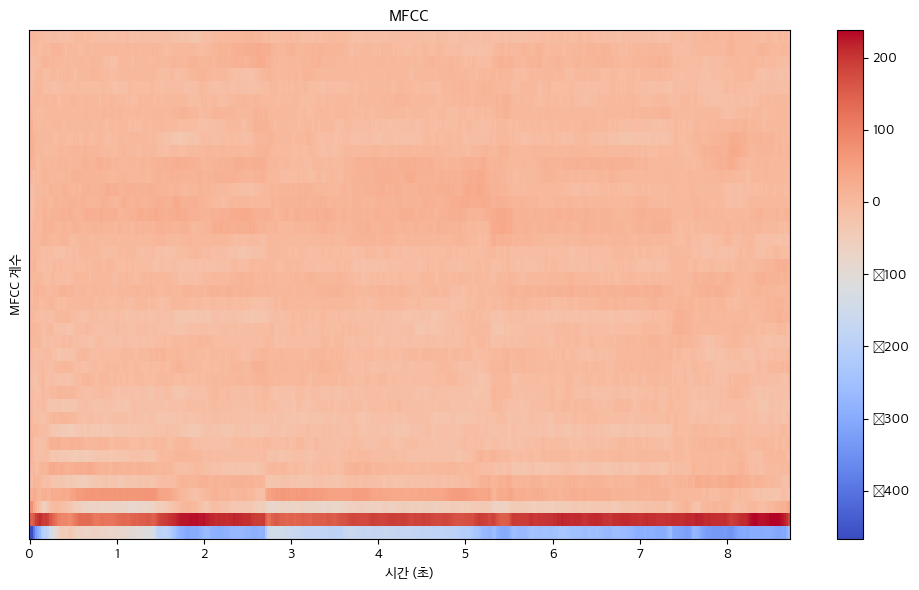

In [16]:
# 입력 오디오 파일 경로 설정
audio_file_path = "/Volumes/T7 Shield/Sonus/data/batch_0000/concerto_sample_1.mp3"  # 예시 오디오 파일 경로

# 오디오 파일에서 특징 추출 및 시각화
print("오디오 파일에서 특징 추출 및 시각화 중...")
n_mfcc = 40
max_len = 174
mfcc = extract_features(audio_file_path, n_mfcc=n_mfcc, max_len=max_len, visualize=True)

In [17]:
# 입력 데이터 전처리
x = np.expand_dims(mfcc, axis=0)  # 채널 추가 (채널, 시간, 주파수)
x = np.expand_dims(x, axis=0)     # 배치 차원 추가 (배치 크기, 채널, 시간, 주파수)
x = x.transpose(0, 1, 3, 2)       # (배치 크기, 채널, 시간, 주파수)
x = torch.from_numpy(x).float().to(device)


In [18]:
# 모델 입력 형태 설정
input_shape = (1, n_mfcc, max_len)
num_classes = 1

# 각 악기에 대해 예측 수행
print("악기 예측 중...")
predictions = {}
for instrument in all_instruments:
    sanitized_instrument = sanitize_name(instrument)
    print(f" - {instrument}")
    # 모델 경로 설정
    model_path = os.path.join(models_output_dir, f"best_model_{sanitized_instrument}.pt")
    if not os.path.exists(model_path):
        print(f"   모델 파일이 존재하지 않습니다: {model_path}")
        continue
    # 모델 생성 및 로드
    model = CNNModel(input_shape, num_classes).to(device)
    model = load_model(model, model_path, device)
    model.eval()
    # 예측
    with torch.no_grad():
        output = model(x)
        pred = output.item()
        predictions[instrument] = pred


/var/folders/sv/jh_ctgn129b2zwq9rr41x8dr0000gn/T/ipykernel_15171/1923294242.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_

악기 예측 중...
 - clarinet
 - violin
 - cello
 - oboe
 - saxophone
 - double bass
 - clash cymbals
 - tuba
 - trumpet
 - flute
 - bass clarinet
 - french horn
 - bassoon
 - tambourine
 - viola
 - trombone



예측 결과:
clarinet: 0.5421 (존재)
violin: 0.0000 (없음)
cello: 0.9999 (존재)
oboe: 0.9962 (존재)
saxophone: 0.0159 (없음)
double bass: 0.8205 (존재)
clash cymbals: 1.0000 (존재)
tuba: 0.0000 (없음)
trumpet: 0.0809 (없음)
flute: 0.0539 (없음)
bass clarinet: 0.0003 (없음)
french horn: 0.9909 (존재)
bassoon: 1.0000 (존재)
tambourine: 0.0000 (없음)
viola: 0.0002 (없음)
trombone: 1.0000 (존재)


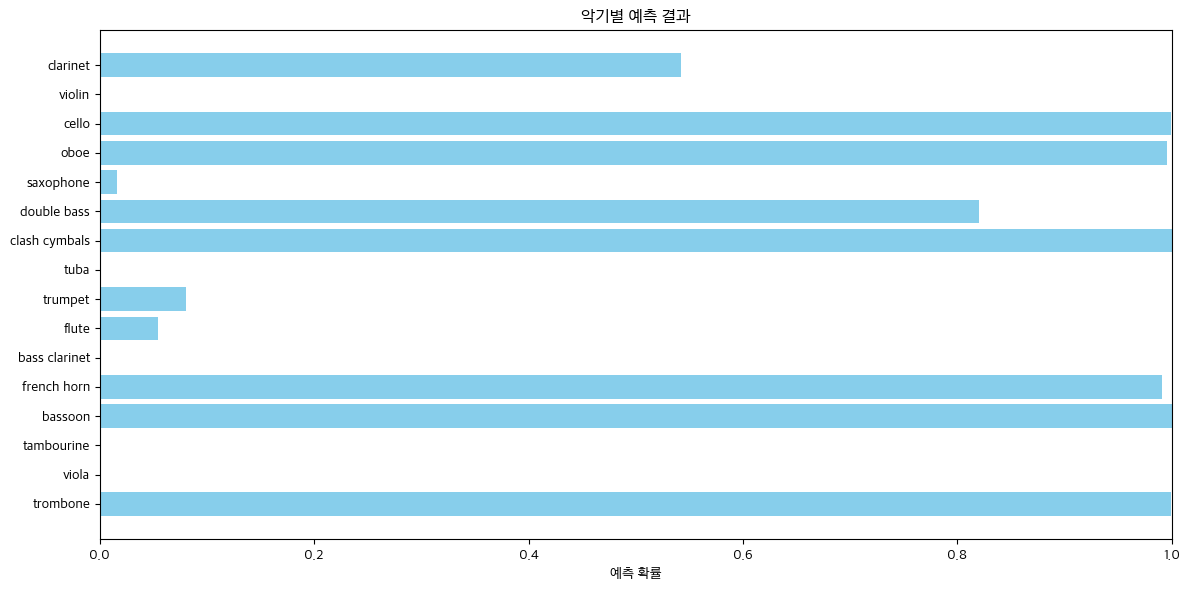

In [19]:
# 결과 출력
print("\n예측 결과:")
for instrument, score in predictions.items():
    print(f"{instrument}: {score:.4f} {'(존재)' if score > 0.5 else '(없음)'}")

# 예측 결과 시각화
instruments = list(predictions.keys())
scores = [predictions[instr] for instr in instruments]

plt.figure(figsize=(12, 6))
plt.barh(instruments, scores, color='skyblue')
plt.xlabel("예측 확률")
plt.title("악기별 예측 결과")
plt.gca().invert_yaxis()
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


# 간소화 모델 평가

In [63]:
# ----------------------------- 라이브러리 임포트 -----------------------------
import os
import json
import numpy as np
import librosa
from tqdm import tqdm
import h5py

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.prune as prune  # 가지치기 추가
import torch.cuda.amp  # 혼합 정밀도 학습을 위한 torch.cuda.amp 추가

import random
import re
import gc
from typing import List, Tuple, Dict, Any

# ----------------------------- 환경 설정 -----------------------------

# 일반 설정
BATCH_SIZE = 512  # 배치 크기 조정 (예: 512)
EPOCHS = 1  # 에포크 수 조정
LEARNING_RATE = 1e-3  # 학습률 조정

# 데이터 관련 설정 (Google Drive 내 경로로 변경)
data_output_dir = "data"  # 데이터 출력 디렉토리
metadata_file = os.path.join(data_output_dir, "metadata.json")  # 메타데이터 파일 경로
hdf5_file = os.path.join(data_output_dir, "preprocessed_data.h5")  # 전처리된 데이터 저장 경로
n_mfcc = 40  # MFCC 계수의 수
max_len = 174  # MFCC 벡터의 최대 길이

# 모델 및 로그 디렉토리 설정 (Google Drive 내 경로로 변경)
models_output_dir = "src/models"  # 모델 저장 디렉토리
os.makedirs(models_output_dir, exist_ok=True)

# 하이퍼파라미터 튜닝 설정
APPLY_HYPERPARAMETER_TUNING = False  # 하이퍼파라미터 튜닝 적용 여부

# ----------------------------- GPU 및 CPU 설정 -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}\n")

# CPU 사용 제한 설정 (필요에 따라 조정 가능)
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
torch.set_num_threads(4)

# ----------------------------- 전처리 함수 정의 -----------------------------
def sanitize_name(name: str) -> str:
    """
    문자열에서 알파벳, 숫자, 언더스코어만 남기고 나머지는 제거합니다.

    Args:
        name (str): 원본 문자열.

    Returns:
        str: 정제된 문자열.
    """
    return re.sub(r"[^a-zA-Z0-9_]", "", name.replace(" ", "_"))


def load_metadata(metadata_path: str) -> List[Dict[str, Any]]:
    """
    메타데이터를 로드합니다.

    Args:
        metadata_path (str): 메타데이터 파일의 경로.

    Returns:
        List[Dict[str, Any]]: 메타데이터 리스트.
    """
    metadata = []
    with open(metadata_path, "r") as f:
        for line in f:
            metadata.append(json.loads(line))
    return metadata


def extract_mfcc(file_path: str, n_mfcc: int = 40, max_len: int = 174) -> np.ndarray:
    """
    오디오 파일에서 MFCC 특징을 추출합니다.

    Args:
        file_path (str): 오디오 파일의 경로.
        n_mfcc (int): 추출할 MFCC 계수의 수.
        max_len (int): MFCC 벡터의 최대 길이.

    Returns:
        np.ndarray: 고정된 크기의 MFCC 배열.
    """
    try:
        y, sr = librosa.load(file_path, sr=None, mono=True)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode="constant")
        else:
            mfcc = mfcc[:, :max_len]
        return mfcc
    except Exception as e:
        print(f"MFCC 추출 실패: {file_path}, 에러: {e}")
        return np.zeros((n_mfcc, max_len))


def preprocess_and_save_data(
    metadata: List[Dict[str, Any]], data_dir: str, hdf5_path: str
) -> None:
    """
    데이터 전처리 및 HDF5 파일로 저장합니다.

    Args:
        metadata (List[Dict[str, Any]]): 메타데이터 리스트.
        data_dir (str): 오디오 데이터가 저장된 디렉토리.
        hdf5_path (str): 저장할 HDF5 파일의 경로.
    """
    total_samples = len(metadata)
    with h5py.File(hdf5_path, "w") as h5f:
        X_ds = h5f.create_dataset(
            "X", shape=(total_samples, n_mfcc, max_len), dtype=np.float32
        )
        Y_list = []
        for idx, data in enumerate(tqdm(metadata, desc="전처리 중")):
            sample_path = os.path.join(
                data_dir, data["relative_path"], data["sample_name"]
            )
            mfcc = extract_mfcc(sample_path, n_mfcc, max_len)
            X_ds[idx] = mfcc
            instruments = data["instruments"]
            Y_list.append(instruments)
        Y_encoded_strings = [json.dumps(instr_list) for instr_list in Y_list]
        dt = h5py.string_dtype(encoding="utf-8")
        Y_ds = h5f.create_dataset(
            "Y", data=np.array(Y_encoded_strings, dtype=object), dtype=dt
        )


def load_preprocessed_data(hdf5_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    전처리된 데이터를 HDF5 파일에서 로드합니다.

    Args:
        hdf5_path (str): HDF5 파일의 경로.

    Returns:
        Tuple[np.ndarray, np.ndarray]: 특징 배열 X와 레이블 리스트 Y.
    """
    with h5py.File(hdf5_path, "r") as h5f:
        X = h5f["X"][:]
        Y = h5f["Y"][:]
    return X, Y


def encode_labels(Y: np.ndarray) -> Tuple[np.ndarray, MultiLabelBinarizer, List[str]]:
    """
    레이블을 이진 벡터로 인코딩합니다.

    Args:
        Y (np.ndarray): 레이블 리스트 (JSON-encoded strings).

    Returns:
        Tuple[np.ndarray, MultiLabelBinarizer, List[str]]: 인코딩된 레이블 배열, 레이블 변환기, 모든 악기 리스트.
    """
    all_instruments = set()
    parsed_Y = []
    for instruments in Y:
        if isinstance(instruments, bytes):
            instruments = instruments.decode("utf-8")
        if isinstance(instruments, str):
            try:
                instruments = json.loads(instruments)
            except json.JSONDecodeError:
                instruments = instruments.split(",")
        if not isinstance(instruments, list):
            instruments = []
        instruments = [instr.strip() for instr in instruments if instr.strip()]
        all_instruments.update(instruments)
        parsed_Y.append(instruments)
    all_instruments = sorted(list(all_instruments))

    if not all_instruments:
        print("경고: 모든 악기 리스트가 비어 있습니다.")

    mlb = MultiLabelBinarizer(classes=all_instruments)
    Y_encoded = mlb.fit_transform(parsed_Y)
    return Y_encoded, mlb, all_instruments


def augment_batch(batch_X: torch.Tensor) -> torch.Tensor:
    """
    데이터 증강을 수행합니다.

    Args:
        batch_X (torch.Tensor): 배치의 MFCC 데이터. (batch_size, channels, height, width)

    Returns:
        torch.Tensor: 증강된 배치의 MFCC 데이터.
    """
    # 데이터 증강 예시 (필요에 따라 수정)
    scale = random.uniform(0.8, 1.2)
    batch_X = batch_X * scale

    noise = torch.randn_like(batch_X) * 0.05
    batch_X = batch_X + noise

    # 주파수 마스킹
    freq_masking = random.randint(0, n_mfcc // 10)
    if freq_masking > 0:
        f0 = random.randint(0, n_mfcc - freq_masking - 1)
        batch_X[:, :, f0 : f0 + freq_masking] = 0

    # 시간 마스킹
    time_masking = random.randint(0, max_len // 10)
    if time_masking > 0:
        t0 = random.randint(0, max_len - time_masking - 1)
        batch_X[:, t0 : t0 + time_masking, :] = 0

    return batch_X

# ----------------------------- 데이터셋 클래스 정의 -----------------------------
class MFCCDataset(Dataset):
    """
    MFCC 데이터를 위한 PyTorch Dataset 클래스
    """

    def __init__(self, X: np.ndarray, Y: np.ndarray, augment: bool = False):
        """
        초기화 함수

        Args:
            X (np.ndarray): 특징 데이터.
            Y (np.ndarray): 레이블 데이터.
            augment (bool): 데이터 증강 여부.
        """
        self.X = X
        self.Y = Y
        self.augment = augment

    def __len__(self) -> int:
        """
        데이터셋의 길이를 반환합니다.

        Returns:
            int: 데이터셋의 길이.
        """
        return len(self.Y)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.X[idx]
        y = self.Y[idx]

        x = np.expand_dims(x, axis=0)  # (1, n_mfcc, max_len)
        x = torch.from_numpy(x).float()

        # Transpose 추가 (채널, 높이, 너비 형태로 변환)
        x = x.transpose(1, 2)  # (1, max_len, n_mfcc)

        if self.augment:
            x = augment_batch(x)

        mean = x.mean()
        std = x.std()
        x = (x - mean) / (std + 1e-6)

        y = torch.tensor(y, dtype=torch.float32)

        return x, y

def calculate_padding(kernel_size: int, stride: int, input_size: int) -> int:
    """
    양자화를 위해 패딩 크기를 계산합니다.

    Args:
        kernel_size (int): 커널 크기.
        stride (int): 스트라이드 크기.
        input_size (int): 입력 크기.

    Returns:
        int: 패딩 크기.
    """
    return max((input_size - 1) * stride + kernel_size - input_size, 0) // 2


# ----------------------------- 모델 정의 -----------------------------
class CNNModel(nn.Module):
    """
    CNN 모델 정의 클래스
    """

    def __init__(
        self,
        input_shape: Tuple[int, int, int],
        num_classes: int,
        dropout_rate: float = 0.5,
        l2_reg: float = 0.001,
    ):
        """
        모델을 초기화합니다.

        Args:
            input_shape (Tuple[int, int, int]): 입력 데이터의 형태.
            num_classes (int): 출력 클래스의 수.
            dropout_rate (float): 드롭아웃 비율.
            l2_reg (float): L2 정규화 계수.
        """
        super(CNNModel, self).__init__()
        input_height, input_width = input_shape[1:]

        # 패딩 계산
        self.padding1 = calculate_padding(3, 1, input_height)
        self.padding2 = calculate_padding(3, 1, input_width)


        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=self.padding1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=self.padding2)
        self.pool2 = nn.MaxPool2d((2, 2))
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=self.padding2)
        self.pool3 = nn.MaxPool2d((2, 2))
        self.bn3 = nn.BatchNorm2d(128)

        conv_output_size = self._get_conv_output(input_shape)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(64, num_classes)
        self.l2_reg = l2_reg

    def _get_conv_output(self, shape: Tuple[int, int, int]) -> int:
        """
        합성곱 계층의 출력을 계산합니다.

        Args:
            shape (Tuple[int, int, int]): 입력 데이터의 형태.

        Returns:
            int: 합성곱 계층 출력의 크기.
        """
        bs = 1
        input = torch.zeros(bs, *shape)
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def _forward_features(self, x: torch.Tensor) -> torch.Tensor:
        """
        합성곱 계층을 통과하는 부분입니다.

        Args:
            x (torch.Tensor): 입력 텐서.

        Returns:
            torch.Tensor: 합성곱 계층의 출력.
        """
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.bn3(x)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        모델의 순전파를 정의합니다.

        Args:
            x (torch.Tensor): 입력 텐서.

        Returns:
            torch.Tensor: 모델의 출력.
        """
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.output_layer(x)  # Sigmoid 제거 (BCEWithLogitsLoss 사용)
        return x  # 로짓을 반환

# ----------------------------- 모델 학습 및 평가 함수 정의 -----------------------------
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion,
    optimizer,
    scheduler,
    num_epochs: int,
    device: torch.device,
):
    """
    모델을 훈련합니다.

    Args:
        model (nn.Module): 학습할 모델.
        train_loader (DataLoader): 훈련 데이터 로더.
        val_loader (DataLoader): 검증 데이터 로더.
        criterion: 손실 함수.
        optimizer: 옵티마이저.
        scheduler: 학습률 스케줄러.
        num_epochs (int): 에포크 수.
        device (torch.device): 장치 (CPU 또는 GPU).
    """
    best_val_loss = float("inf")
    patience = 10
    trigger_times = 0

    # 혼합 정밀도 스케일러 초기화
    scaler = torch.cuda.amp.GradScaler()  # torch.cuda.amp 사용

    print("모델 학습 시작...\n")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0

        # 훈련 단계
        train_bar = tqdm(
            train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] 훈련 중", leave=False
        )
        for batch_X, batch_Y in train_bar:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            optimizer.zero_grad()
            
            with torch.amp.autocast("cpu"):  # 혼합 정밀도 적용
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                # L2 정규화는 옵티마이저의 weight_decay로 처리하므로 추가하지 않음

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * batch_X.size(0)
            total_samples += batch_X.size(0)

            # 배치별 손실 업데이트
            train_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        epoch_loss = running_loss / total_samples

        # 검증 단계
        model.eval()
        val_loss = 0.0
        total_samples = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            val_bar = tqdm(
                val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] 검증 중", leave=False
            )
            for batch_X, batch_Y in val_bar:
                batch_X = batch_X.to(device)
                batch_Y = batch_Y.to(device)

                with torch.amp.autocast("cpu"):  # 혼합 정밀도 적용
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_Y)
                    # L2 정규화는 옵티마이저의 weight_decay로 처리하므로 추가하지 않음

                val_loss += loss.item() * batch_X.size(0)
                total_samples += batch_X.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_Y.cpu().numpy())

        avg_val_loss = val_loss / total_samples

        # F1-score, Precision, Recall 계산
        if len(np.unique(all_labels)) > 1:
            epoch_f1 = f1_score(all_labels, all_preds, average="samples", zero_division=0)
            epoch_precision = precision_score(
                all_labels, all_preds, average="samples", zero_division=0
            )
            epoch_recall = recall_score(
                all_labels, all_preds, average="samples", zero_division=0
            )
        else:
            epoch_f1 = 0.0
            epoch_precision = 0.0
            epoch_recall = 0.0

        # 에포크별 성능 지표 출력
        tqdm.write(
            f"Epoch [{epoch+1}/{num_epochs}] 완료 - "
            f"Train Loss: {epoch_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, "
            f"Val Precision: {epoch_precision:.4f}, Val Recall: {epoch_recall:.4f}, Val F1-Score: {epoch_f1:.4f}"
        )

        # 학습률 스케줄러 단계
        scheduler.step(avg_val_loss)

        # Early Stopping 체크
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0
            save_model(
                model,
                os.path.join(models_output_dir, "best_model.pt"),
            )
            tqdm.write(f"--> 최고 검증 손실 기록: {best_val_loss:.4f} 저장됨.\n")
        else:
            trigger_times += 1
            tqdm.write(f"--> EarlyStopping 트리거 횟수: {trigger_times}/{patience}\n")
            if trigger_times >= patience:
                tqdm.write("Early stopping 발생. 학습 중단.\n")
                break

    tqdm.write(f"모델 학습 완료. 최고 검증 손실: {best_val_loss:.4f}\n")


def evaluate_model(
    model: nn.Module, test_loader: DataLoader, criterion, device: torch.device
) -> Tuple[float, float, List[float], List[float]]:
    """
    모델을 평가합니다.

    Args:
        model (nn.Module): 평가할 모델.
        test_loader (DataLoader): 테스트 데이터 로더.
        criterion: 손실 함수.
        device (torch.device): 장치 (CPU 또는 GPU).

    Returns:
        Tuple[float, float, List[float], List[float]]: 테스트 손실, 정확도, 예측 값 리스트, 실제 값 리스트.
    """
    model.eval()
    test_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            with torch.amp.autocast("cpu"):  # 혼합 정밀도 적용
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                # L2 정규화는 옵티마이저의 weight_decay로 처리하므로 추가하지 않음

            test_loss += loss.item() * batch_X.size(0)
            total_samples += batch_X.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_Y.cpu().numpy())

    avg_test_loss = test_loss / total_samples

    return avg_test_loss, None, all_preds, all_labels


def save_model(model: nn.Module, path: str) -> None:
    """
    모델을 지정된 경로에 저장합니다.

    Args:
        model (nn.Module): 저장할 모델.
        path (str): 저장할 파일 경로.
    """
    torch.save(model.state_dict(), path)
    print(f"모델 저장 완료: {path}")


def load_model(model: nn.Module, path: str, device: torch.device) -> nn.Module:
    """
    모델을 지정된 경로에서 로드합니다.

    Args:
        model (nn.Module): 로드할 모델 구조.
        path (str): 모델 파일 경로.
        device (torch.device): 장치 (CPU 또는 GPU).

    Returns:
        nn.Module: 로드된 모델.
    """
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

# ----------------------------- 메인 실행 부분 -----------------------------
if __name__ == "__main__":
    # 메타데이터 로드
    print("메타데이터 로드 중...")
    metadata = load_metadata(metadata_file)
    print(f"메타데이터 로드 완료: {len(metadata)} 샘플")

    # 데이터 전처리 및 저장
    if not os.path.exists(hdf5_file):
        print("데이터 전처리 시작...")
        preprocess_and_save_data(metadata, data_output_dir, hdf5_file)
        print("데이터 전처리 및 저장 완료.")
    else:
        print("전처리된 데이터 파일이 존재합니다. 로드합니다.")

    # 전처리된 데이터 로드
    print("전처리된 데이터 로드 중...")
    X, Y = load_preprocessed_data(hdf5_file)
    print(f"전처리된 데이터 로드 완료: X shape={X.shape}, Y shape={Y.shape}")

    # 레이블 인코딩
    print("레이블 인코딩 중...")
    Y_encoded, mlb, all_instruments = encode_labels(Y)
    print(f"레이블 인코딩 완료: {len(all_instruments)} 종류의 악기")

    if len(all_instruments) == 0:
        raise ValueError("레이블 인코딩 실패: 악기 리스트가 비어 있습니다.")

    # 데이터셋 분할
    print("데이터셋 분할 중...")
    X_train, X_temp, Y_train, Y_temp = train_test_split(
        X, Y_encoded, test_size=0.2, random_state=42
    )
    X_val, X_test, Y_val, Y_test = train_test_split(
        X_temp, Y_temp, test_size=0.5, random_state=42
    )
    print(f"데이터셋 분할 완료:")
    print(f" - 훈련 세트: {X_train.shape[0]} 샘플")
    print(f" - 검증 세트: {X_val.shape[0]} 샘플")
    print(f" - 테스트 세트: {X_test.shape[0]} 샘플")

    # 클래스 가중치 계산
    print("클래스 가중치 계산 중...")
    # 멀티레이블 분류이므로 각 클래스에 대해 가중치를 계산
    class_weights = []
    for i in range(Y_encoded.shape[1]):
        classes = np.unique(Y_train[:, i])
        if len(classes) > 1:
            cw = compute_class_weight(
                class_weight="balanced", classes=classes, y=Y_train[:, i]
            )
            class_weights.append(cw[1])  # Positive class weight
        else:
            class_weights.append(1.0)  # Default weight

    class_weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    print(f"클래스 가중치: {class_weight_tensor}")

    # 하이퍼파라미터 튜닝 적용 여부에 따른 처리
    if APPLY_HYPERPARAMETER_TUNING:
        print("하이퍼파라미터 튜닝을 수행합니다...")
        # 하이퍼파라미터 튜닝 코드 생략
    else:
        learning_rate = LEARNING_RATE
        dropout_rate = 0.5
        num_epochs = EPOCHS

    # 모델 구축
    input_shape = (1, n_mfcc, max_len)  # 수정된 입력 형태
    num_classes = Y_encoded.shape[1]  # 멀티레이블 분류를 위한 클래스 수
    model = CNNModel(input_shape, num_classes, dropout_rate=dropout_rate).to(device)

    # 옵티마이저와 손실 함수 설정
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # L2 정규화 포함
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight_tensor)

    # 학습률 스케줄러 설정
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # 데이터셋 및 데이터로더 생성
    train_dataset = MFCCDataset(X_train, Y_train, augment=True)
    val_dataset = MFCCDataset(X_val, Y_val, augment=False)
    test_dataset = MFCCDataset(X_test, Y_test, augment=False)

    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
    )

    # 모델 훈련
    print("모델 훈련 시작...")
    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=num_epochs,
        device=device,
    )
    print("모델 훈련 완료.")


    # # 모델 가지치기 적용 (Pruning)
    # print("모델 가지치기 시작...")
    # parameters_to_prune = (
    #     (model.conv1, 'weight'),
    #     (model.conv2, 'weight'),
    #     (model.conv3, 'weight'),
    #     (model.fc1, 'weight'),
    #     (model.fc2, 'weight'),
    #     (model.output_layer, 'weight'),
    # )
    # for module, param in parameters_to_prune:
    #     prune.l1_unstructured(module, param, amount=0.2)  # 20% 가지치기
    # print("모델 가지치기 완료.")

    # 모델 양자화 적용 (Quantization)
    print("모델 양자화 시작...")
    model.eval()
    model.cpu()
    model.qconfig = torch.quantization.default_qconfig
    torch.quantization.prepare(model, inplace=True)
    # 캘리브레이션 (간단히 검증 데이터로 수행)
    with torch.no_grad():
        for batch_X, _ in tqdm(val_loader, desc="양자화 캘리브레이션 중", leave=False):
            outputs = model(batch_X)
    torch.quantization.convert(model, inplace=True)
    model.to(device)
    print("모델 양자화 완료.")

    # 모델 저장
    save_model(model, os.path.join(models_output_dir, "optimized_model.pt"))

    # CPU에서 평가
    device_cpu = torch.device("cpu")  # CPU 장치 설정
    model.to(device_cpu)  # 모델을 CPU로 이동
    model.cpu()


    # 테스트 데이터 평가
    print("테스트 데이터 평가 중...")
    avg_test_loss, _, all_preds, all_labels = evaluate_model(
        model=model, test_loader=test_loader, criterion=criterion, device=device_cpu
    )
    print(f"테스트 손실: {avg_test_loss}")

    # F1-score 계산
    if len(np.unique(all_labels)) > 1:
        f1 = f1_score(all_labels, all_preds, average="samples", zero_division=0)
        print(f"F1-score: {f1}")
    else:
        print("F1-score 계산 불가: 테스트 세트에 하나의 클래스만 존재합니다.")

    # 분류 리포트 출력
    if len(np.unique(all_labels)) > 1:
        report = classification_report(
            all_labels,
            all_preds,
            target_names=mlb.classes_,
            zero_division=0
        )
        print(report)
    else:
        print("분류 리포트 출력 불가: 테스트 세트에 하나의 클래스만 존재합니다.")

    # 메모리 정리
    del model
    del train_loader
    del val_loader
    del test_loader
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()

    print("\n모든 작업 완료.")

    # ----------------------------- 개별 악기 예측 코드 -----------------------------
    def predict_instruments(audio_file_path: str, model_path: str, mlb: MultiLabelBinarizer) -> List[str]:
        """
        개별 오디오 파일에 대해 악기 예측을 수행합니다.

        Args:
            audio_file_path (str): 예측할 오디오 파일의 경로.
            model_path (str): 학습된 모델의 경로.
            mlb (MultiLabelBinarizer): 레이블 인코딩기.

        Returns:
            List[str]: 예측된 악기 리스트.
        """
        # MFCC 추출
        mfcc = extract_mfcc(audio_file_path, n_mfcc, max_len)
        mfcc = torch.from_numpy(mfcc).float()  # (n_mfcc, max_len)
        mfcc = mfcc.transpose(0, 1)  # (max_len, n_mfcc)
        mfcc = mfcc.unsqueeze(0)  # (1, max_len, n_mfcc)
        mfcc = mfcc.permute(0, 2, 1)  # (1, n_mfcc, max_len)
        mfcc = mfcc.unsqueeze(0).to(device)  # (1, 1, n_mfcc, max_len)
        mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)

        # 모델 로드
        model = CNNModel(input_shape, num_classes).to(device)
        model = load_model(model, model_path, device)
        model.eval()

        # 예측
        with torch.no_grad():
            output = model(mfcc)
            sigmoid_output = torch.sigmoid(output).cpu().numpy()[0]
            predicted = sigmoid_output > 0.5
            predicted_instruments = mlb.classes_[predicted]

        return predicted_instruments.tolist()

    # 예측할 오디오 파일 경로
    audio_file_path = "data/batch_0000/concerto_sample_1.mp3"  # 실제 오디오 파일 경로로 변경

    # 예측 수행
    print("개별 오디오 파일에 대한 악기 예측 중...")
    predicted_instruments = predict_instruments(
        audio_file_path,
        os.path.join(models_output_dir, "optimized_model.pt"),
        mlb
    )
    print(f"예측된 악기: {predicted_instruments}")


사용 중인 디바이스: cpu

메타데이터 로드 중...
메타데이터 로드 완료: 231980 샘플
전처리된 데이터 파일이 존재합니다. 로드합니다.
전처리된 데이터 로드 중...
전처리된 데이터 로드 완료: X shape=(231980, 40, 174), Y shape=(231980,)
레이블 인코딩 중...
레이블 인코딩 완료: 16 종류의 악기
데이터셋 분할 중...
데이터셋 분할 완료:
 - 훈련 세트: 185584 샘플
 - 검증 세트: 23198 샘플
 - 테스트 세트: 23198 샘플
클래스 가중치 계산 중...
클래스 가중치: tensor([0.9408, 0.9405, 0.9382, 0.9408, 0.9441, 0.9405, 0.9424, 0.9412, 0.9411,
        0.9395, 0.9421, 0.9443, 0.9401, 0.9431, 0.9435, 0.9429])


/var/folders/sv/jh_ctgn129b2zwq9rr41x8dr0000gn/T/ipykernel_10600/725517503.py:444: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # torch.cuda.amp 사용
/Users/reo/miniforge3/envs/torch-mac/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


모델 훈련 시작...
모델 학습 시작...



Epoch [1/1] 훈련 중:   0%|          | 0/363 [00:00<?, ?it/s]/Users/reo/miniforge3/envs/torch-mac/lib/python3.12/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [1/1] 완료 - Train Loss: 0.5151, Val Loss: 0.4449, Val Precision: 0.6623, Val Recall: 0.6156, Val F1-Score: 0.5825
모델 저장 완료: src/models/best_model.pt
--> 최고 검증 손실 기록: 0.4449 저장됨.

모델 학습 완료. 최고 검증 손실: 0.4449

모델 훈련 완료.
모델 양자화 시작...


RuntimeError: Didn't find engine for operation quantized::conv2d_prepack NoQEngine